# Spectrum analysis with contrastive learning

Author: Christoph Weniger, June 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch

## Model definition

The model is a simple function that samples from $p(x|z)$. We assume that $z$ live on the unit hypercube and have a flat prior (the same as in MultiNest).

In [2]:
def model(z, sigma = 0.1):
    x = np.linspace(0, 20, 1000)
    t  = np.cos(x)*z[0]
    t += np.sin(x)*z[1]
    t += np.cos(x*2)*z[2]
    t += np.sin(x*2)*z[3]
    t += np.cos(x*z[4])*0.3
    t += np.sin(x*z[5])*0.3
    t += (x/20)*z[6]
    t += (x/20)**2*z[7]
    n = np.random.randn(*t.shape)*sigma
    return t + n

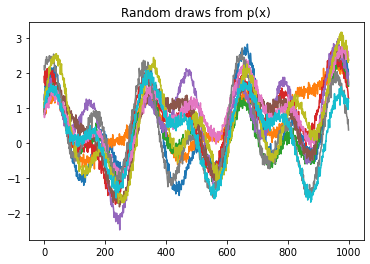

In [3]:
for i in range(10):
    z = np.random.rand(8)
    x = model(z)
    plt.title("Random draws from p(x)")
    plt.plot(x)

## Target data

Our goal is to analyze data $x_0$. True parameters are $z_0$.

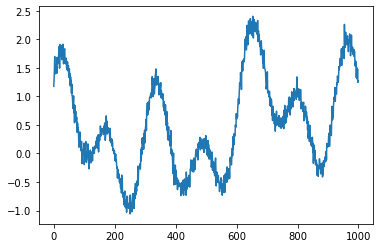

In [4]:
z0 = np.ones(8)*0.5
x0 = model(z0, sigma = 0.1)
plt.plot(x0)

## Definition of head network

A network that maps n-dim data $x$ onto some set of 1-dim features $y$ that enter the posterior estimation (think of "test statistics").  For intrinsically 1-dim data, this step is optional. One could set `head = None` below.

In [5]:
class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.pool = torch.nn.MaxPool1d(4)
        
    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten()
        return x

## Initialize SWYFT

Upon initialization the model, dimensionality of $z$, and target data $x_0$ have to be provided.  The device parameter is optional, GPU acceleration requires a properly installed GPU (`torch.cuda.is_available()` should return `True`).

In [6]:
sw = swyft.SWYFT(model, 8, x0, device = 'cuda:0')

## Data generation and training rounds

In [7]:
sw.round(n_sims = 3000, n_train = 20000, lr = 1e-4, head = Head().cuda())

  7%|▋         | 204/3000 [00:00<00:01, 2034.80it/s]

Round:  0
Generate samples from constrained prior: z~pc(z)
Generate corresponding draws x ~ p(x|z)


  0%|          | 4/20000 [00:00<08:58, 37.11it/s]

Network optimization


100%|██████████| 20000/20000 [06:33<00:00, 50.80it/s]


## Retrieve approximate marginal posteriors for various training rounds

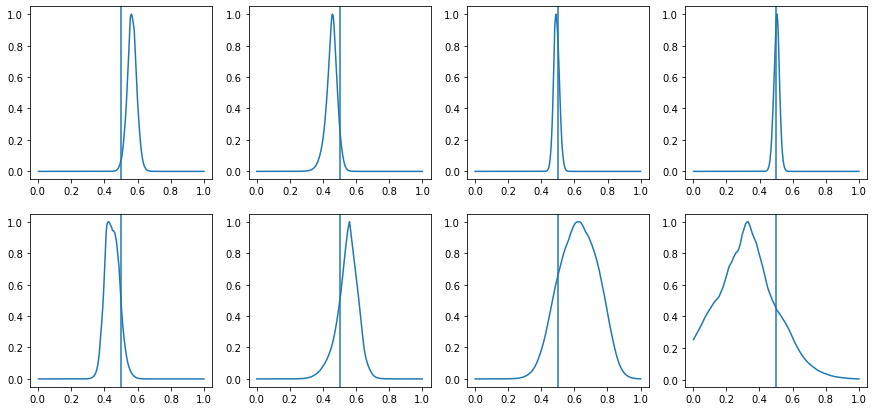

In [8]:
post0 = sw.get_posteriors(nround=0)
plt.figure(figsize = (15, 7))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(post0[i]['z'], np.exp(post0[i]['lnL']))
    plt.axvline(z0[i])

In [9]:
sw.round(n_sims = 3000, n_train = 20000, lr = 1e-4, head = Head().cuda(), combine = False)

Round:  1
Generate samples from constrained prior: z~pc(z)


  7%|▋         | 220/3000 [00:00<00:01, 2195.20it/s]

Constrained posterior volume: 0.002906379538270758
Generate corresponding draws x ~ p(x|z)


  0%|          | 5/20000 [00:00<06:40, 49.98it/s]

Network optimization


100%|██████████| 20000/20000 [06:11<00:00, 53.80it/s]


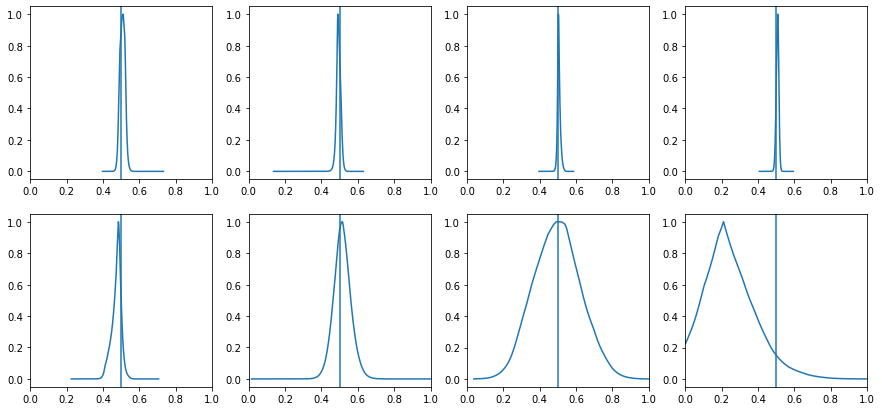

In [10]:
post1 = sw.get_posteriors(nround=1)
plt.figure(figsize = (15, 7))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(post1[i]['z'], np.exp(post1[i]['lnL']))
    plt.axvline(z0[i])
    plt.xlim([0, 1])

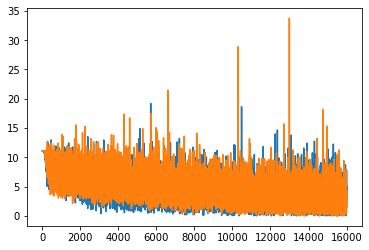

In [11]:
plt.plot(sw.loss_store[0])
plt.plot(sw.loss_store[1])

In [12]:
sw.round(n_sims = 5000, n_train = 20000, lr = 1e-4, head = Head().cuda(), combine = False)

Round:  2
Generate samples from constrained prior: z~pc(z)


  4%|▍         | 217/5000 [00:00<00:02, 2169.36it/s]

Constrained posterior volume: 5.4693253414799995e-05
Generate corresponding draws x ~ p(x|z)


  0%|          | 5/20000 [00:00<06:56, 47.99it/s]

Network optimization


100%|██████████| 20000/20000 [06:19<00:00, 52.64it/s]


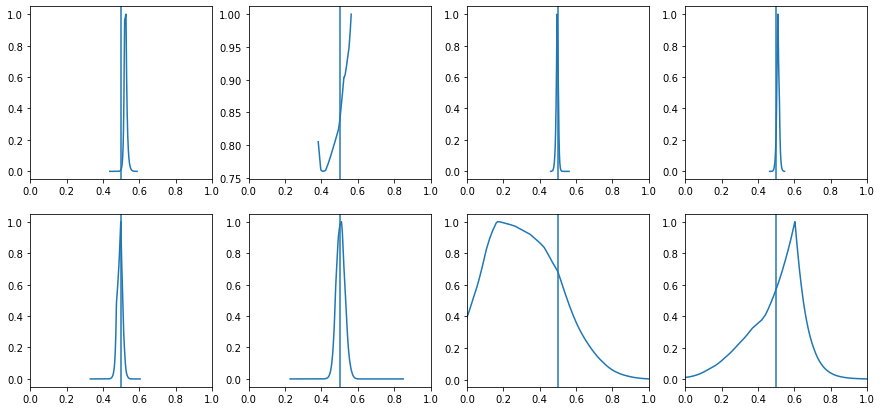

In [13]:
post2 = sw.get_posteriors(nround=2)
plt.figure(figsize = (15, 7))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(post2[i]['z'], np.exp(post2[i]['lnL']))
    plt.axvline(z0[i])
    plt.xlim([0, 1])